# EMI of Megaconstellations, LOFAR observation planning

## License
```
EMI of Megaconstellations, LOFAR observation planning.
Copyright (C) 2020+  Benjamin Winkel (bwinkel@mpifr.de)
                     Federico Di Vruno (F.DiVruno@skatelescope.org)

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycraf import conversions as cnv
from pycraf import antenna, geometry
from astropy import units as u, constants as const
import cysgp4

Define observer position.

In [2]:
obs_lon, obs_lat, obs_alt = 6.8689, 52.9089, 0.  # deg, deg, km

In [3]:
ras_observer = cysgp4.PyObserver(obs_lon, obs_lat, obs_alt)

Read in Starlink TLEs

In [4]:
with open('starlink_20211013.txt') as f:
    tle_txt = f.read()

In [5]:
tle_txt[:1000]

'STARLINK-24             \n1 44238U 19029D   21286.08449342  .00017553  00000-0  87771-3 0  9999\n2 44238  52.9935 171.0793 0001727  90.6692 269.4499 15.17530386132191\nSTARLINK-61             \n1 44249U 19029Q   21285.33696952  .00013949  00000-0  59724-3 0  9991\n2 44249  52.9883 144.5287 0007172  86.8890 273.2926 15.23054256131534\nSTARLINK-71             \n1 44252U 19029T   21286.09633370  .00022340  00000-0  10434-2 0  9993\n2 44252  52.9982 171.0911 0001423 101.4968 258.6186 15.19750646132199\nSTARLINK-43             \n1 44257U 19029Y   21285.63489866  .00129585  00000-0  20286-2 0  9991\n2 44257  52.9976  38.9924 0003501 343.9233  16.1664 15.52825149133163\nSTARLINK-80             \n1 44282U 19029AZ  21285.79393894  .00052479  00000-0  15020-2 0  9998\n2 44282  53.0194  88.8138 0002350 292.4071  67.6681 15.35455795131834\nSTARLINK-1007           \n1 44713U 19074A   21286.07899839  .00001639  00000-0  12889-3 0  9992\n2 44713  53.0545 207.9920 0001948  68.1714 291.9482 15.0640797

In [6]:
# sl_tles = cysgp4.tles_from_text(tle_txt)
# bugfix for my older cysgp4 installation
sl_tles = cysgp4.tles_from_text(tle_txt.replace('\n', '\r\n'))

Choose one satellite for epoch

In [7]:
sl_tle = sl_tles[0]
pydt = sl_tle.epoch

In [8]:
pydt

<PyDateTime: 2021-10-13 02:01:40.231488 UTC>

Try to find a good start time and satellite such that the sat crosses close to zenith.

In [9]:
target_az, target_el = 0., 88.
eps = 0.3  # how close we want to have the satellite pass the beam pos

In [10]:
for sl_tle in sl_tles:
    mjds = pydt.mjd + np.arange(-0.5, 0.5, 1 / 86400)
    result = cysgp4.propagate_many(  # see cysgp4 manual for details
        mjds,
        sl_tle,
        ras_observer,
        )
    topo_pos = result['topo']
    topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., i] for i in range(4))
    ang_dist = geometry.true_angular_distance(
        target_az * u.deg, target_el * u.deg,
        topo_pos_az * u.deg, topo_pos_el * u.deg,
        )
    if np.any(ang_dist < eps * u.deg):
        break

In [11]:
print('Satellite {:s} is close to Zenith:'.format(sl_tle.tle_strings()[0].strip()))
print(sl_tle)

Satellite STARLINK-1029 is close to Zenith:
Norad Number:         44734
Int. Designator:      19074X  
Epoch:                2021-10-12 18:13:41.130048 UTC
Orbit Number:         10734
Mean Motion Dt2:        0.00003318
Mean Motion Ddt6:       0.00000000
Eccentricity:           0.00017600
BStar:                  0.00024670
Inclination:           53.00040000
Right Ascending Node: 129.39010000
Argument Perigee:      79.73630000
Mean Anomaly:         280.38230000
Mean Motion:           15.05593145



Restrict trajectory to elevation > 20 deg:

In [12]:
mask = topo_pos_el > 20
mjds_m = mjds[mask]
topo_pos_az_m = topo_pos_az[mask]
topo_pos_el_m = topo_pos_el[mask]
topo_pos_dist_m = topo_pos_dist[mask]
ang_dist_m = ang_dist[mask]

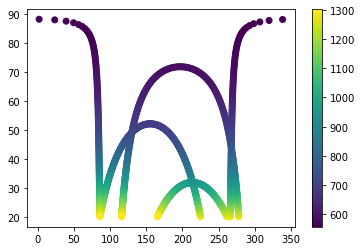

In [13]:
plt.scatter(topo_pos_az_m, topo_pos_el_m, c=topo_pos_dist_m)
plt.colorbar()
plt.show()

That's still to much. Show just a few seconds...

In [14]:
_idx = np.argmin(ang_dist)
mask2 = np.zeros_like(mask)
mask2[_idx - 5:_idx + 5] = True
mjds_m = mjds[mask2]
topo_pos_az_m = topo_pos_az[mask2]
topo_pos_el_m = topo_pos_el[mask2]
topo_pos_dist_m = topo_pos_dist[mask2]
ang_dist_m = ang_dist[mask2]

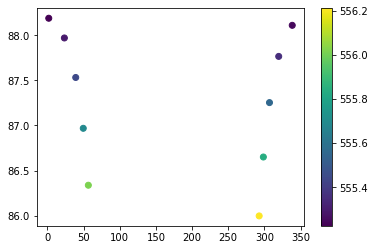

In [15]:
plt.scatter(topo_pos_az_m, topo_pos_el_m, c=topo_pos_dist_m)
plt.colorbar()
plt.show()

In [16]:
ang_speed = geometry.true_angular_distance(
    topo_pos_az_m[1:] * u.deg, topo_pos_el_m[1:] * u.deg,
    topo_pos_az_m[:-1] * u.deg, topo_pos_el_m[:-1] * u.deg,
    ) / u.s
print('maximum angular speed: {:.2f}'.format(np.max(ang_speed)))

maximum angular speed: 0.75 deg / s


LOFAR parameters

In [17]:
freq = 150 * u.MHz
wlen = const.c / freq
diameter = 200 * u.m  # equivalent diameter of a dish with same properties
eta_a = 15 * u.percent  # adjusted to meet the sensitivity according to RA.1631
hpbw_station = 4.7 * u.deg
hpbw_beam = 0.3 * u.deg
tsys = 200 * u.K  # please check! (this includes astronomical background!)
bw_channel = 12. * u.kHz
Gamma_mb = 1.7 * u.K / u.Jy

In [18]:
Grx = antenna.ras_pattern(0 * u.deg, diameter, wlen, eta_a)
Grx

<Decibel 41.70992108 dB>

Find the HPBW for the RA.1631 antenna model (which is very simple). For a filled dish, one would have to account for $\eta_\mathrm{A}$, but for LOFAR things are different (we don't have a filled aperture).

In [19]:
# hpbw = (np.sqrt(3 / 2.5e-3) * wlen / diameter / eta_a).to(cnv.dimless) * u.deg
hpbw = (np.sqrt(3 / 2.5e-3) * wlen / diameter).to(cnv.dimless) * u.deg
hpbw

<Quantity 0.34617051 deg>

In [20]:
eff_area = cnv.eff_area_from_gain(Grx, freq)
eff_area

<Quantity 4712.38898038 m2>

Sanity check the sensitivity

In [21]:
cnv.gamma_from_eff_area(eff_area)

<Quantity 1.70658532 K / Jy>

In [22]:
eff_integration_time = hpbw / ang_speed

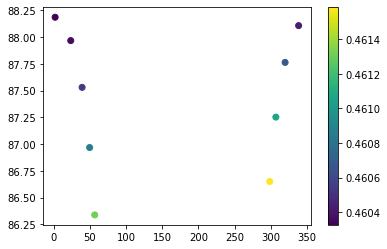

In [23]:
plt.scatter(topo_pos_az_m[1:], topo_pos_el_m[1:], c=eff_integration_time)
plt.colorbar()
plt.show()

Let's assume that we can integrate for 0.5 seconds (will be longer for much lower elevations)

In [24]:
integration_time = 0.5 * u.s

In [25]:
# Tx (Sat) parameters

Gtx = 0 * cnv.dBi  # assume isotropic EMI leakage

Efield = 30 * cnv.dB_uV_m
p_tx_nu_peak =(cnv.ptx_from_efield(
    Efield, 10 * u.m, 0 * cnv.dBi
    ) / 120 / u.kHz).to(cnv.dBm_MHz)
# <Decibel -45.56001949 dB(mW / MHz)>
 
p_tx_nu = p_tx_nu_peak.to(u.W / u.Hz)
p_tx_chan = p_tx_nu.to(u.W / u.Hz) * bw_channel
p_tx_nu.to(cnv.dBm_MHz), p_tx_chan.to(cnv.dBm)

(<Decibel -45.56001949 dB(mW / MHz)>, <Decibel -64.76820703 dB(mW)>)

In [26]:
p_rx_chan = cnv.prx_from_ptx(p_tx_chan, Gtx, Grx, topo_pos_dist_m[1:] * u.km, freq)

In [27]:
p_rx_chan.to(cnv.dBm)

<Decibel [-153.92685762, -153.92240008, -153.91931362, -153.91760118,
          -153.91726439, -153.91830357, -153.92071773, -153.92450456,
          -153.92966049] dB(mW)>

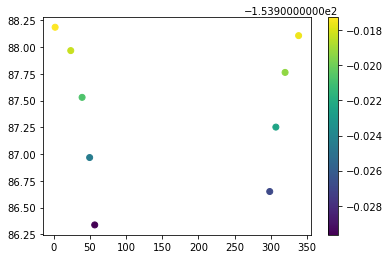

In [28]:
plt.scatter(topo_pos_az_m[1:], topo_pos_el_m[1:], c=p_rx_chan.to(cnv.dBm))
plt.colorbar()
plt.show()

In [29]:
tsou = cnv.t_a_from_prx_nu(p_rx_chan.to(u.W) / bw_channel)
tsou

<Quantity [1.22185555, 1.22311029, 1.22397984, 1.22446255, 1.22455751,
           1.22426454, 1.22358418, 1.22251774, 1.22106723] K>

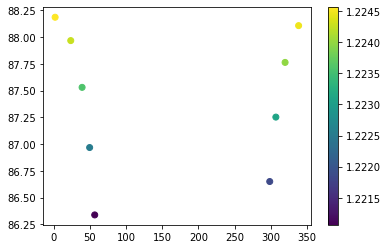

In [30]:
plt.scatter(topo_pos_az_m[1:], topo_pos_el_m[1:], c=tsou.to(u.K))
plt.colorbar()
plt.show()

In [31]:
trms = (tsys / np.sqrt(bw_channel * integration_time)).to(u.K)
trms

<Quantity 2.5819889 K>

Compare with 1 min integration time

In [32]:
(tsys / np.sqrt(bw_channel * 60 * u.s)).to(u.K)

<Quantity 0.23570226 K>

This would be a $5\sigma$ event at full spectral resolution, but needs 120 stacked spectra!

Alternatively, use pfd and use K/Jy:

In [33]:
pfd_nu = cnv.powerflux_from_ptx(p_tx_chan, topo_pos_dist_m[1:] * u.km, Gtx) / bw_channel
pfd_nu.to(u.Jy)

<Quantity [0.71596511, 0.71670035, 0.71720987, 0.71749273, 0.71754837,
           0.7173767 , 0.71697803, 0.71635314, 0.71550319] Jy>

In [34]:
pfd_nu.to(u.Jy) * Gamma_mb

<Quantity [1.21714069, 1.21839059, 1.21925679, 1.21973764, 1.21983223,
           1.21954038, 1.21886266, 1.21780033, 1.21635542] K>

Confirmed!

For completeness, we need to take into accout the primary beam pattern, assume Gaussian

In [35]:
def gauss(phi, sigma):
    return np.exp(-phi ** 2 / 2 / sigma ** 2)  # / np.sqrt(2 * np.pi) / sigma

In [36]:
taper = gauss(ang_dist_m, hpbw_station / 2.35)

In [37]:
taper

<Quantity [0.17760622, 0.33211821, 0.53983863, 0.76230447, 0.93479163,
           0.99523803, 0.91990459, 0.73826959, 0.51460133, 0.31168156]>

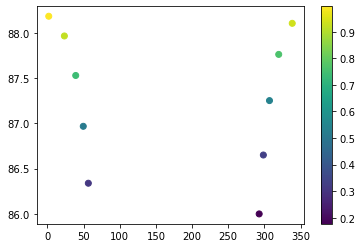

In [38]:
plt.scatter(topo_pos_az_m, topo_pos_el_m, c=taper)
plt.colorbar()
plt.show()

(Note, each dot represents 1-s of data, i.e., two 0.5-sec integrations)

Try to estimate the number of satellites per hour, by checking how much samples we get in the station beam (will need a correction factor, perhaps 50%?)

In [44]:
target_az, target_el = 0., 88.
eps = 2.3  # how close we want to have the satellite pass the beam pos
corr_factor = 0.5

In [48]:
_samples = 0
target_samples = 120
mjd_start = pydt.mjd
while _samples < target_samples: 
    # note: could speed this up by doing a batch calculation for 60 s of
    # data in each iteration
    result = cysgp4.propagate_many(  # see cysgp4 manual for details
        mjd_start,
        sl_tles,
        ras_observer,
        )
    mjd_start += 1 / 86400
    
    topo_pos = result['topo']
    topo_pos_az, topo_pos_el, _, _ = (topo_pos[..., i] for i in range(4))
    
    # make this somewhat more efficient by pre-filtering low elevations
    mask = topo_pos_el > 70
    topo_pos_az, topo_pos_el = topo_pos_az[mask], topo_pos_el[mask]
    
    if np.count_nonzero(mask) == 0:
        continue

    ang_dist = geometry.true_angular_distance(
        target_az * u.deg, target_el * u.deg,
        topo_pos_az * u.deg, topo_pos_el * u.deg,
        )
    _samples += corr_factor * 2 * np.count_nonzero(ang_dist < eps * u.deg)
    

In [49]:
_samples, (mjd_start - pydt.mjd) * 86400

(120.0, 1742.0004072133452)